In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

#### 1. Use the included 3 sets of optimal features over the holding period 2003-2018 and an AdaBoostClassifier. Use Optuna to find hyper-parameters for the training period 2001-01-01 to 2004-01-01 and use these hyper-parameters and the sets of optimal features to compute the maximum drawdown for each of them.

In [2]:
raw_data = pd.read_pickle(r'dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [4]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
df_1 = data.loc['2001-01-01':'2004-01-01']
df_valid = data.loc['2004-04-01':'2004-07-01']
df_test = data.loc['2004-10-01':'2005-01-01']

In [6]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [7]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

In [8]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [9]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [10]:
qrt_profit = (train_1_stock_returns*y_1).resample('Q').sum().to_list()
percentage_changes = [(qrt_profit[i] / qrt_profit[i-1] - 1) for i in range(1, len(qrt_profit))]


In [11]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None,prev_profit=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    profit = []
    profit.append(prev_profit)
    preds = ada_clf.predict(val)
    profit_next = (preds * val_rets).sum()
    profit.append(profit_next)
    all_return = [(profit[i] / profit[i-1] - 1) for i in range(1, len(profit))]
    period_max_drawdown = max_drawdown(all_return)
 
    return period_max_drawdown

In [12]:
study = optuna.create_study(direction="minimize")
from functools import partial

In [15]:
%%time
study.optimize(partial(objective,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns,prev_profit=qrt_profit), n_trials=20,n_jobs=-1)

CPU times: user 13min 37s, sys: 15.1 s, total: 13min 52s
Wall time: 5min 10s


In [ ]:
study.best_params

In [16]:
max_depth = study.best_params['max_depth']
n_estimators = study.best_params['n_estimators']
learning_rate = study.best_params['learning_rate']

In [17]:
best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

In [18]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),**best_params)

In [19]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [20]:
import _pickle as cPickle

In [21]:
optimal_feature = []

In [25]:
with open(r'shap_features_ada.pkl','rb') as f:
    optimal_feature = cPickle.load(f)

optimal_feature_1 = optimal_feature[0]

optimal_feature_2 = []

with open(r'shap_features_ada_01.pkl','rb') as f:
    optimal_feature_2 = cPickle.load(f)
    
optimal_feature_2 = optimal_feature_2[0]

optimal_feature_3 = []

with open(r'shap_features_ada_02.pkl','rb') as f:
    optimal_feature_3 = cPickle.load(f)

optimal_feature_3 = optimal_feature_3[0]

In [26]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

- Set 1

In [27]:
scalers_1 = [StandardScaler() for i in range(len(start_dates)-1)]     
     
opt_training_data = [pd.DataFrame(scalers_1[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_1[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_1[i].transform(test_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]

In [28]:
x_1 = [1]
ret_1 = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_1.append(profit_i)
        num_names = len(opt_test_data[i])
        x_1.append(x_1[i] + (x_1[i]/num_names)*profit_i)

In [29]:
def max_dd(returns):
    i = np.argmax(np.maximum.accumulate(returns) - returns)
    j = np.argmax(returns[:i])
    dd = np.abs(returns[j] - returns[i])
    plt.plot(returns);
    plt.plot([i, j], [returns[i], returns[j]], 'o', color='Red', markersize=10)
    print(f'maxmum drawdown during the period is {np.abs(returns[j] - returns[i])}')
    return dd

maxmum drawdown during the period is 0.7354453426147312


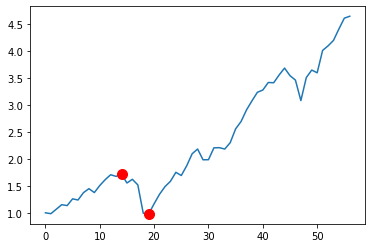

In [30]:
dd_1 = max_dd(x_1)

- Set 2

In [31]:
scalers_2 = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers_2[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_2[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_2[i].transform(test_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]

maxmum drawdown during the period is 0.7211264821866115


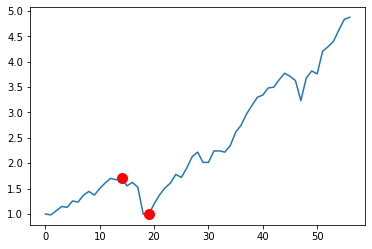

In [32]:
x_2 = [1]
ret_2 = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_2.append(profit_i)
        num_names = len(opt_test_data[i])
        x_2.append(x_2[i] + (x_2[i]/num_names)*profit_i)
        
# it is the max drawdown for second set of feature
dd_2 = max_dd(x_2)

- Set 3

maxmum drawdown during the period is 0.6922255221646691


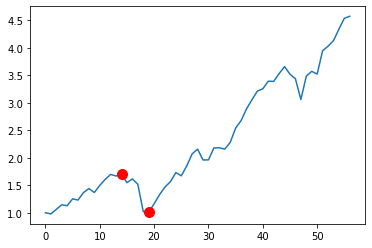

In [33]:
scalers_3 = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers_3[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_3[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_3[i].transform(test_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]

x_3 = [1]
ret_3 = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_3.append(profit_i)
        num_names = len(opt_test_data[i])
        x_3.append(x_3[i] + (x_3[i]/num_names)*profit_i)
        

# it is the max drawdown for third set of feature
dd_3 = max_dd(x_3)

#### 2. Try different Optuna objectives such as accuracy and max drawdown on the period 2001-01-01 to 2004-04-01

In [34]:
def objective_2(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy



In [35]:
study_2 = optuna.create_study(direction="maximize")
from functools import partial

In [36]:
%%time
study_2.optimize(partial(objective_2,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)


CPU times: user 13min 45s, sys: 14.6 s, total: 14min
Wall time: 3min 7s


In [37]:
study_2.best_params


{'max_depth': 2, 'n_estimators': 50, 'learning_rate': 0.30000000000000004}

In [38]:
max_depth_2 = study_2.best_params['max_depth']
n_estimators_2 = study_2.best_params['n_estimators']
learning_rate_2 = study_2.best_params['learning_rate']

In [39]:
best_params_2 = {'n_estimators': n_estimators_2, 'learning_rate': learning_rate_2}

In [40]:
ada_clf_acc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth_2),**best_params_2)

- Set 1

maxmum drawdown during the period is 0.6360148962517431


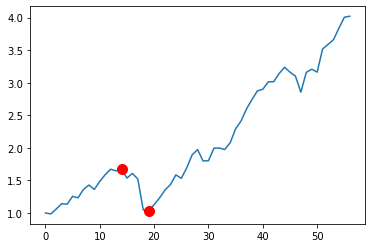

In [41]:
scalers_1_acc = [StandardScaler() for i in range(len(start_dates)-1)]  
        
opt_training_data = [pd.DataFrame(scalers_1_acc[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_1_acc[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_1_acc[i].transform(test_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]

x_1_acc = [1]
ret_1_acc = []

for i in range(len(start_dates)-1):
        
        ada_clf_acc.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_acc.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_1_acc.append(profit_i)
        num_names = len(opt_test_data[i])
        x_1_acc.append(x_1_acc[i] + (x_1_acc[i]/num_names)*profit_i)
        
dd_1_acc = max_dd(x_1_acc)


- Set 2

maxmum drawdown during the period is 0.5663329768508405


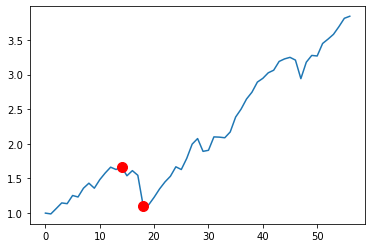

In [42]:
scalers_2_acc = [StandardScaler() for i in range(len(start_dates)-1)]

opt_training_data = [pd.DataFrame(scalers_2_acc[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_2_acc[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_2_acc[i].transform(test_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]

x_2_acc = [1]
ret_2_acc = []

for i in range(len(start_dates)-1):
        
        ada_clf_acc.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_acc.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_2_acc.append(profit_i)
        num_names = len(opt_test_data[i])
        x_2_acc.append(x_2_acc[i] + (x_2_acc[i]/num_names)*profit_i)
        
# it is the max drawdown for second set of feature with new objective
dd_2_acc = max_dd(x_2_acc)

- Set 3

maxmum drawdown during the period is 0.6339264023953406


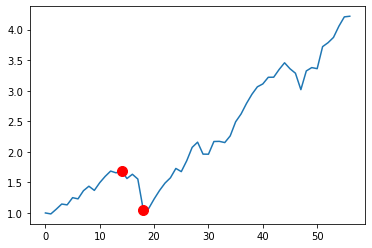

In [43]:
scalers_3_acc = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers_3_acc[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_3_acc[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_3_acc[i].transform(test_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]

x_3_acc = [1]
ret_3_acc = []

for i in range(len(start_dates)-1):
        
        ada_clf_acc.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_acc.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_3_acc.append(profit_i)
        num_names = len(opt_test_data[i])
        x_3_acc.append(x_3_acc[i] + (x_3_acc[i]/num_names)*profit_i)
        
# it is the max drawdown for third set of feature
dd_3_acc = max_dd(x_3_acc)

In [44]:
def objective_3(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    profit = (preds * val_rets).sum()
 
    return profit

In [48]:
study_3 = optuna.create_study(direction="maximize")
from functools import partial

In [49]:
%%time
study_3.optimize(partial(objective_3,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)

CPU times: user 10min 16s, sys: 11.1 s, total: 10min 27s
Wall time: 1min 48s


In [50]:
study_3.best_params

{'max_depth': 5, 'n_estimators': 30, 'learning_rate': 0.5}

In [51]:
max_depth_3 = study_3.best_params['max_depth']
n_estimators_3 = study_3.best_params['n_estimators']
learning_rate_3 = study_3.best_params['learning_rate']
best_params_3 = {'n_estimators': n_estimators_3, 'learning_rate': learning_rate_3}

In [52]:
ada_clf_profit = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth_3),**best_params_3)

- Set 1

maxmum drawdown during the period is 0.4848671885074729


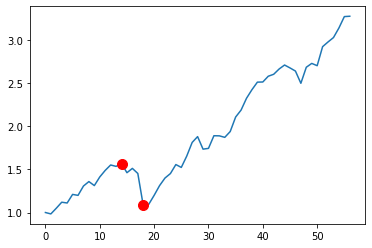

In [53]:
scalers_1_profit = [StandardScaler() for i in range(len(start_dates)-1)]  
        
opt_training_data = [pd.DataFrame(scalers_1_profit[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_1_profit[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_1_profit[i].transform(test_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]


x_1_profit = [1]
ret_1_profit = []

for i in range(len(start_dates)-1):
        
        ada_clf_profit.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_profit.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_1_profit.append(profit_i)
        num_names = len(opt_test_data[i])
        x_1_profit.append(x_1_profit[i] + (x_1_profit[i]/num_names)*profit_i)
        
        
# it is the max drawdown for first set of feature with objective of maximizing profit
dd_1_profit = max_dd(x_1_profit)

- Set 2

In [54]:
scalers_2_profit = [StandardScaler() for i in range(len(start_dates)-1)]

opt_training_data = [pd.DataFrame(scalers_2_profit[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_2_profit[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_2_profit[i].transform(test_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]


In [55]:
x_2_profit = [1]
ret_2_profit = []

for i in range(len(start_dates)-1):
        
        ada_clf_profit.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_profit.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_2_profit.append(profit_i)
        num_names = len(opt_test_data[i])
        x_2_profit.append(x_2_profit[i] + (x_2_profit[i]/num_names)*profit_i)

maxmum drawdown during the period is 0.2602888964933543


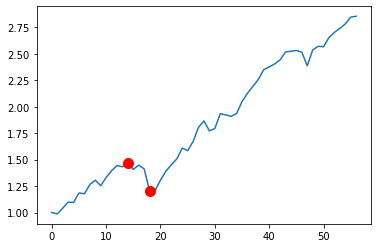

In [56]:
dd_2_profit = max_dd(x_2_profit)

- Set 3

In [57]:
scalers_3_profit = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers_3_profit[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_3_profit[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_3_profit[i].transform(test_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]

In [58]:
x_3_profit = [1]
ret_3_profit = []

for i in range(len(start_dates)-1):
        
        ada_clf_profit.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_profit.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_3_profit.append(profit_i)
        num_names = len(opt_test_data[i])
        x_3_profit.append(x_3_profit[i] + (x_3_profit[i]/num_names)*profit_i)

maxmum drawdown during the period is 0.47717772598989083


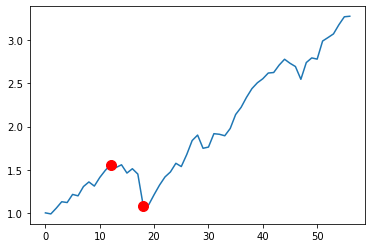

In [59]:
dd_3_profit = max_dd(x_3_profit)

#### 3. Try to change the labels as in Homework 1 and 2 (or try to use your own way to make labels) and try to find a strategy that has both good Sharpe Ratio and a small max drawdown.

In [60]:
raw_data = pd.read_pickle(r'dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [61]:
def f_new(x):
    if x > 0.05:
        return 1
    elif -0.1 <= x <= 0.05:
        return 0
    else:
        return -1

In [62]:
data['rel_performance'] = data['pred_rel_return'].apply(f_new)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [63]:
df_1 = data.loc['2001-01-01':'2004-01-01']
df_valid = data.loc['2004-04-01':'2004-07-01']
df_test = data.loc['2004-10-01':'2005-01-01']

In [64]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [65]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

qrt_profit = (train_1_stock_returns*y_1).resample('Q').sum().to_list()
percentage_changes = [(qrt_profit[i] / qrt_profit[i-1] - 1) for i in range(1, len(qrt_profit))]

In [66]:
def objective_4(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None,prev_profit=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    profit = []
    profit.append(prev_profit)
    preds = ada_clf.predict(val)
    profit_next = (preds * val_rets).sum()
    profit.append(profit_next)
    all_return = [(profit[i] / profit[i-1] - 1) for i in range(1, len(profit))]
    period_max_drawdown = max_drawdown(all_return)
 
    return period_max_drawdown

In [67]:
study_4 = optuna.create_study(direction="minimize")
from functools import partial

In [68]:
%%time
study_4.optimize(partial(objective_4,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns,prev_profit=qrt_profit), n_trials=20,n_jobs=-1)

CPU times: user 10min 29s, sys: 9.51 s, total: 10min 39s
Wall time: 2min 13s


In [69]:
study_4.best_params

{'max_depth': 4, 'n_estimators': 10, 'learning_rate': 0.30000000000000004}

In [70]:
max_depth_4 = study_4.best_params['max_depth']
n_estimators_4 = study_4.best_params['n_estimators']
learning_rate_4 = study_4.best_params['learning_rate']

best_params_4 = {'n_estimators': n_estimators_4, 'learning_rate': learning_rate_4}
ada_clf_new = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth_4),**best_params_4)

In [71]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [72]:
scalers_1_new = [StandardScaler() for i in range(len(start_dates)-1)]     
     
opt_training_data = [pd.DataFrame(scalers_1_new[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_1_new[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_1_new[i].transform(test_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]

In [73]:
x_1_new = [1]
ret_1_new = []

for i in range(len(start_dates)-1):
        
        ada_clf_new.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_new.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_1_new.append(profit_i)
        num_names = len(opt_test_data[i])
        x_1_new.append(x_1_new[i] + (x_1_new[i]/num_names)*profit_i)

maxmum drawdown during the period is 0.11762099626057121


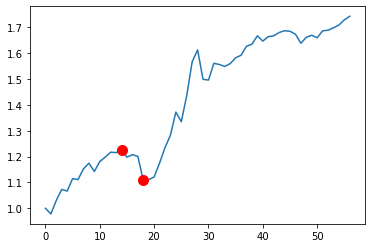

In [74]:
dd_1_new = max_dd(x_1_new)

In [75]:
scalers_2_new = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers_2_new[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_2_new[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_2_new[i].transform(test_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]

maxmum drawdown during the period is 0.11349489880883001


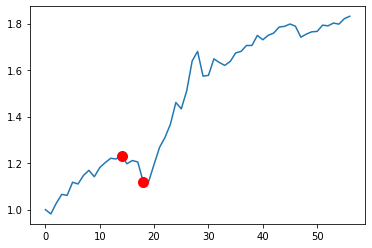

In [76]:
x_2_new = [1]
ret_2_new = []

for i in range(len(start_dates)-1):
        
        ada_clf_new.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_new.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_2_new.append(profit_i)
        num_names = len(opt_test_data[i])
        x_2_new.append(x_2_new[i] + (x_2_new[i]/num_names)*profit_i)
        
dd_2_new = max_dd(x_2_new)

maxmum drawdown during the period is 0.10383190567009914


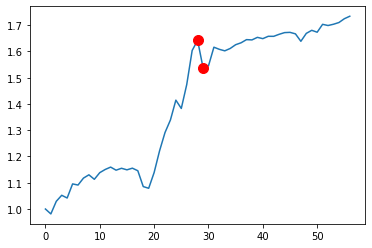

In [77]:
scalers_3_new = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers_3_new[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_3_new[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_3_new[i].transform(test_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]

x_3_new = [1]
ret_3_new = []

for i in range(len(start_dates)-1):
        
        ada_clf_new.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_new.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_3_new.append(profit_i)
        num_names = len(opt_test_data[i])
        x_3_new.append(x_3_new[i] + (x_3_new[i]/num_names)*profit_i)
        
dd_3_new = max_dd(x_3_new)

In [80]:
def objective_5(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy

study_5 = optuna.create_study(direction="maximize")
from functools import partial


In [81]:
%%time
study_5.optimize(partial(objective_5,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)

CPU times: user 16min 58s, sys: 14 s, total: 17min 12s
Wall time: 2min 53s


In [82]:
study_5.best_params

{'max_depth': 1, 'n_estimators': 40, 'learning_rate': 0.2}

In [83]:
max_depth_5 = study_5.best_params['max_depth']
n_estimators_5 = study_5.best_params['n_estimators']
learning_rate_5 = study_5.best_params['learning_rate']

best_params_5 = {'n_estimators': n_estimators_5, 'learning_rate': learning_rate_5}

ada_clf_acc_new = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth_5),**best_params_5)

- Set 1

maxmum drawdown during the period is 0.11624138745287027


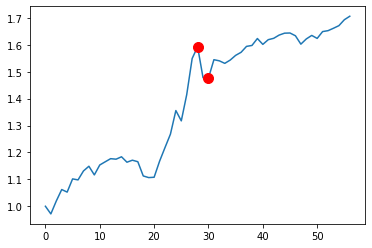

In [84]:
scalers_1_acc_new = [StandardScaler() for i in range(len(start_dates)-1)]  
        
opt_training_data = [pd.DataFrame(scalers_1_acc_new[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_1_acc_new[i].fit_transform(training_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_1_acc_new[i].transform(test_frames[i][optimal_feature_1].values),columns=optimal_feature_1) for i in range(len(start_dates)-1)]

x_1_acc_new = [1]
ret_1_acc_new = []

for i in range(len(start_dates)-1):
        
        ada_clf_acc_new.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_acc_new.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_1_acc_new.append(profit_i)
        num_names = len(opt_test_data[i])
        x_1_acc_new.append(x_1_acc_new[i] + (x_1_acc_new[i]/num_names)*profit_i)
        
# it is the max drawdown for first set of feature with new objective and new label
dd_1_acc_new = max_dd(x_1_acc_new)


maxmum drawdown during the period is 0.12212254148286283


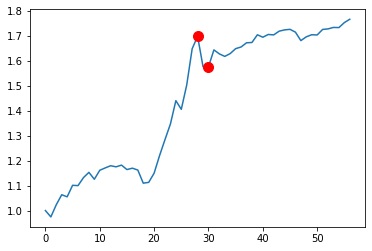

In [85]:
scalers_2_acc_new = [StandardScaler() for i in range(len(start_dates)-1)]

opt_training_data = [pd.DataFrame(scalers_2_acc_new[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_2_acc_new[i].fit_transform(training_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_2_acc_new[i].transform(test_frames[i][optimal_feature_2].values),columns=optimal_feature_2) for i in range(len(start_dates)-1)]

x_2_acc_new = [1]
ret_2_acc_new = []

for i in range(len(start_dates)-1):
        
        ada_clf_acc_new.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_acc_new.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_2_acc_new.append(profit_i)
        num_names = len(opt_test_data[i])
        x_2_acc_new.append(x_2_acc_new[i] + (x_2_acc_new[i]/num_names)*profit_i)
        
# it is the max drawdown for second set of feature with new objective and new label
dd_2_acc_new = max_dd(x_2_acc_new)

maxmum drawdown during the period is 0.10471657191758621


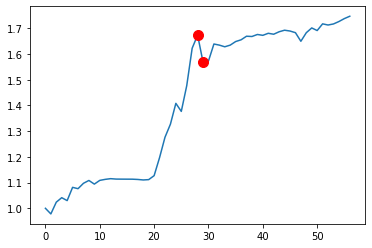

In [86]:
# try the third set of features with new objective
scalers_3_acc_new = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers_3_acc_new[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers_3_acc_new[i].fit_transform(training_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers_3_acc_new[i].transform(test_frames[i][optimal_feature_3].values),columns=optimal_feature_3) for i in range(len(start_dates)-1)]

x_3_acc_new = [1]
ret_3_acc_new = []

for i in range(len(start_dates)-1):
        
        ada_clf_acc_new.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf_acc_new.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_3_acc_new.append(profit_i)
        num_names = len(opt_test_data[i])
        x_3_acc_new.append(x_3_acc_new[i] + (x_3_acc_new[i]/num_names)*profit_i)
        
# it is the max drawdown for third set of feature
dd_3_acc_new = max_dd(x_3_acc_new)